# Boston Housing Price Prediction

## Background:
The Boston Housing dataset contains information collected by the U.S Census Service concerning housing in the area of Boston, Massachusetts. This dataset is widely used for beginner to intermediate machine learning tasks and offers a mix of categorical and numerical features. The aim is to predict the median value of owner-occupied homes.

## Problem Statement:
Develop a machine learning model to predict the median value of owner-occupied homes in Boston based on various predictor variables (features). This will help real estate agents, homeowners, and potential buyers to get a better understanding of the housing market in Boston and assist in making informed decisions.


In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pylab as pl
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from math import sqrt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# The data URL points to the Boston housing dataset from the CMU StatLib repository
data_url = "http://lib.stat.cmu.edu/datasets/boston"

# Read the data from the URL:
# - The data is space-separated
# - The first 22 rows are skipped as they don't contain data
# - There's no header row, so header=None
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# The data is formatted such that every two rows in the raw_df corresponds to a single data point:
# - The even-indexed rows (0, 2, 4, ...) contain most of the features for each data point
# - The odd-indexed rows (1, 3, 5, ...) contain the remaining features and the target variable
# The following line restructures the data into a single array where each row is a complete data point
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])

# The target variable (median home value) is extracted from the third column of the odd-indexed rows
target = raw_df.values[1::2, 2]

In [3]:
# Convert the processed data into a pandas DataFrame for easier manipulation and analysis
boston_df = pd.DataFrame(data)

# Add the target variable (median home value) as a new column named 'target'
boston_df['target'] = target

# Define the column names for the dataset based on its documentation
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Assign the column names to the DataFrame for clarity
boston_df.columns = column_names

### Variables Description

- **CRIM**: 
    - Per capita crime rate by town
- **ZN**: 
    - Proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: 
    - Proportion of non-retail business acres per town
- **CHAS**: 
    - Charles River dummy variable 
    - 1 if tract bounds river; 0 otherwise
- **NOX**: 
    - Nitric oxides concentration (parts per 10 million)
- **RM**: 
    - Average number of rooms per dwelling
- **AGE**: 
    - Proportion of owner-occupied units built prior to 1940
- **DIS**: 
    - Weighted distances to five Boston employment centers
- **RAD**: 
    - Index of accessibility to radial highways
- **TAX**: 
    - Full-value property-tax rate per $10,000
- **PTRATIO**: 
    - Pupil-teacher ratio by town
- **B**: 
    - 1000(Bk - 0.63)^2 where Bk is the proportion of Black residents by town
- **LSTAT**: 
    - % lower status of the population
- **MEDV**: 
    - Median value of owner-occupied homes in $1000's 
    - (This is our target variable)


In [4]:
# Get the first few rows (default is 5) of the dataset to quickly view its structure and content
head = boston_df.head()

# Generate descriptive statistics of the dataset
description = boston_df.describe()

# Display the descriptive statistics to get a sense of the data distribution and characteristics
description

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
# Display the top few rows of the DataFrame to visually inspect the data
head

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


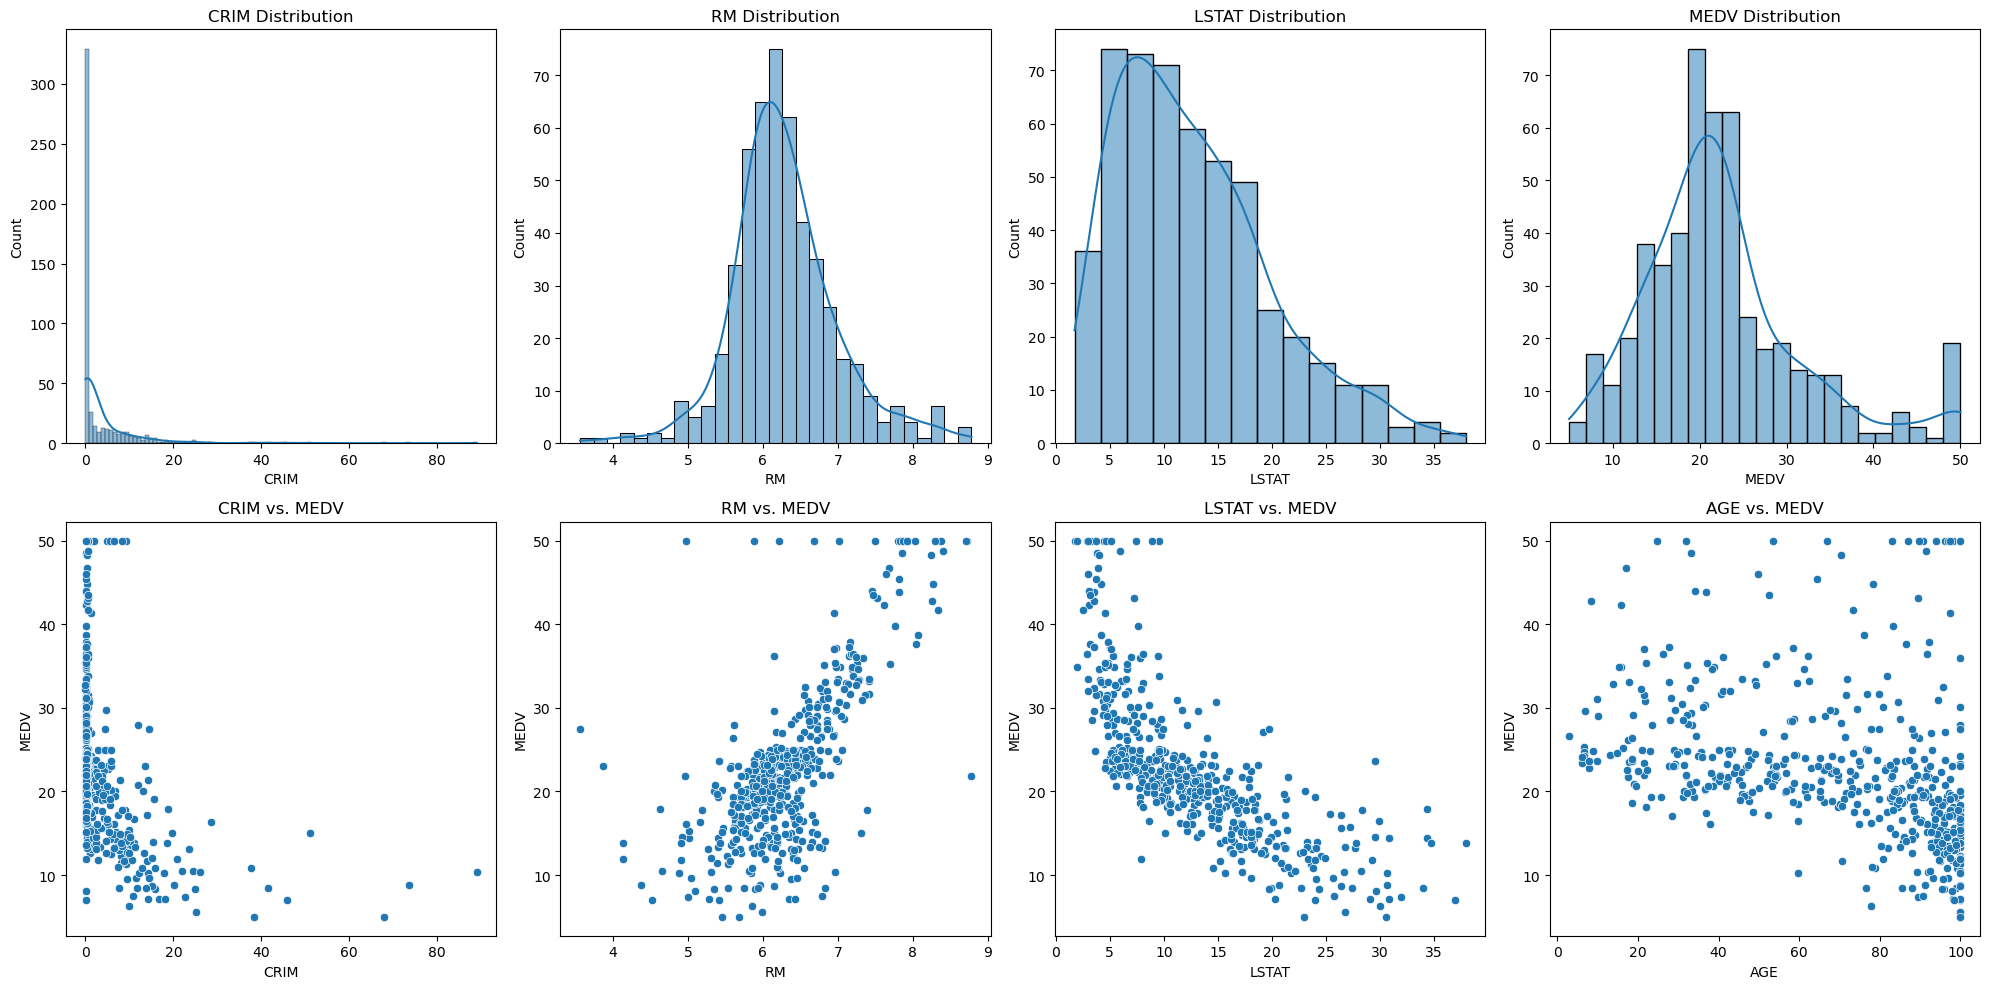

In [6]:
# Plotting distributions of some selected features and their relationship with MEDV

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Distribution plots
sns.histplot(boston_df['CRIM'], kde=True, ax=axes[0, 0]).set_title('CRIM Distribution')
sns.histplot(boston_df['RM'], kde=True, ax=axes[0, 1]).set_title('RM Distribution')
sns.histplot(boston_df['LSTAT'], kde=True, ax=axes[0, 2]).set_title('LSTAT Distribution')
sns.histplot(boston_df['MEDV'], kde=True, ax=axes[0, 3]).set_title('MEDV Distribution')

# Scatter plots against MEDV
sns.scatterplot(x=boston_df['CRIM'], y=boston_df['MEDV'], ax=axes[1, 0]).set_title('CRIM vs. MEDV')
sns.scatterplot(x=boston_df['RM'], y=boston_df['MEDV'], ax=axes[1, 1]).set_title('RM vs. MEDV')
sns.scatterplot(x=boston_df['LSTAT'], y=boston_df['MEDV'], ax=axes[1, 2]).set_title('LSTAT vs. MEDV')
sns.scatterplot(x=boston_df['AGE'], y=boston_df['MEDV'], ax=axes[1, 3]).set_title('AGE vs. MEDV')

plt.tight_layout()
plt.show()


## Histograms:

### CRIM Distribution:
The crime rate (CRIM) is heavily right-skewed, meaning a majority of towns have a low crime rate, with a few exceptions where the crime rate is significantly higher.

### RM Distribution:
The average number of rooms (RM) per dwelling is approximately normally distributed, with a peak around 6 rooms.

### LSTAT Distribution:
The percentage of the lower status of the population (LSTAT) is slightly right-skewed, indicating that there are some areas with a high percentage of lower-status residents.

### MEDV Distribution:
The median value of owner-occupied homes (MEDV) is somewhat normally distributed, but with some noticeable peaks, especially at the higher value end.

## Scatter plots:

### CRIM vs. MEDV:
As crime rate (CRIM) increases, the median value of homes (MEDV) seems to decrease. This suggests that higher crime rates are associated with lower home values.

### RM vs. MEDV:
There's a clear positive correlation between the average number of rooms (RM) and MEDV. This indicates that homes with more rooms tend to have higher median values.

### LSTAT vs. MEDV:
The percentage of the lower status of the population (LSTAT) has a strong negative correlation with MEDV. As LSTAT increases, MEDV decreases, suggesting that areas with a higher percentage of lower-status residents tend to have lower home values.

### AGE vs. MEDV:
The proportion of owner-occupied units built prior to 1940 (AGE) has a somewhat negative relationship with MEDV, indicating that older houses might have slightly lower median values. However, the relationship isn't as strong as the previous plots.


(CRIM       0
 ZN         0
 INDUS      0
 CHAS       0
 NOX        0
 RM         0
 AGE        0
 DIS        0
 RAD        0
 TAX        0
 PTRATIO    0
 B          0
 LSTAT      0
 MEDV       0
 dtype: int64,
              CRIM          ZN       INDUS        CHAS         NOX          RM  \
 count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
 mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
 std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
 min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
 25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
 50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
 75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
 max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   
 
               AGE         DIS         RAD       

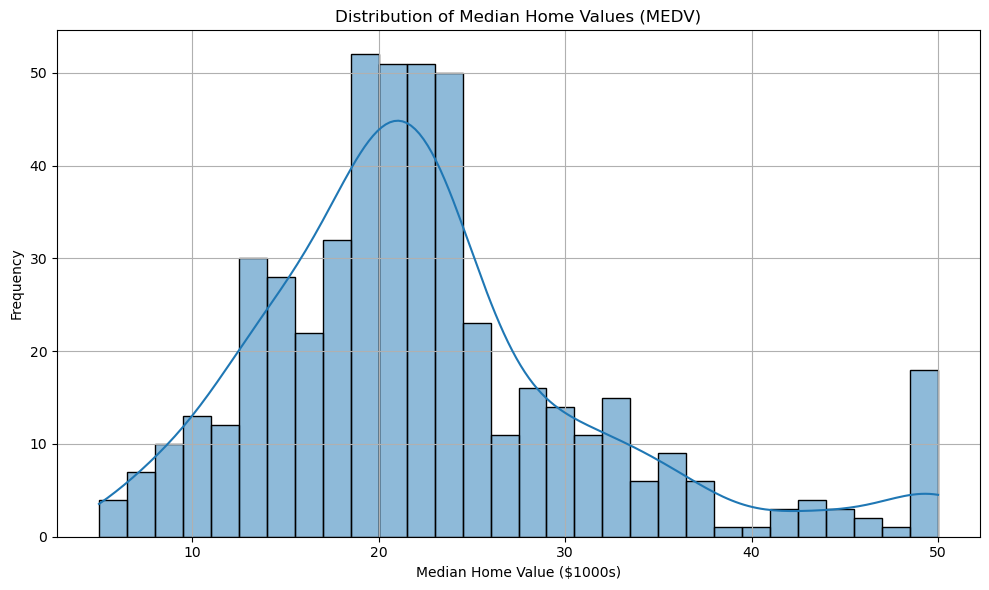

In [7]:
# Check for missing values
missing_values = boston_df.isnull().sum()

# Describe the statistics of the dataset
statistics = boston_df.describe()

# Visualize the distribution of the target variable (`MEDV`)
plt.figure(figsize=(10, 6))
sns.histplot(boston_df['MEDV'], bins=30, kde=True)
plt.title('Distribution of Median Home Values (MEDV)')
plt.xlabel('Median Home Value ($1000s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()

missing_values, statistics

## Missing Values:
The dataset has no missing values for any of the columns, which is great as it means we won't have to perform any imputation or data cleaning in that regard.

## Descriptive Statistics:
The descriptive statistics for the dataset have already been discussed in a previous interpretation. Still, to reiterate, it provides a comprehensive summary of the central tendency, dispersion, and shape of the distribution of the dataset's features.

## Distribution of Median Home Values (MEDV):
The histogram depicts the distribution of the target variable, MEDV. The median home values seem to be somewhat normally distributed, with a few noticeable peaks. There's also a notable cap at $50,000, suggesting that houses with values above this might have been capped at this value.


In [8]:
# Split the data into training and testing sets (80% train, 20% test)
X = boston_df.drop('MEDV', axis=1)
y = boston_df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

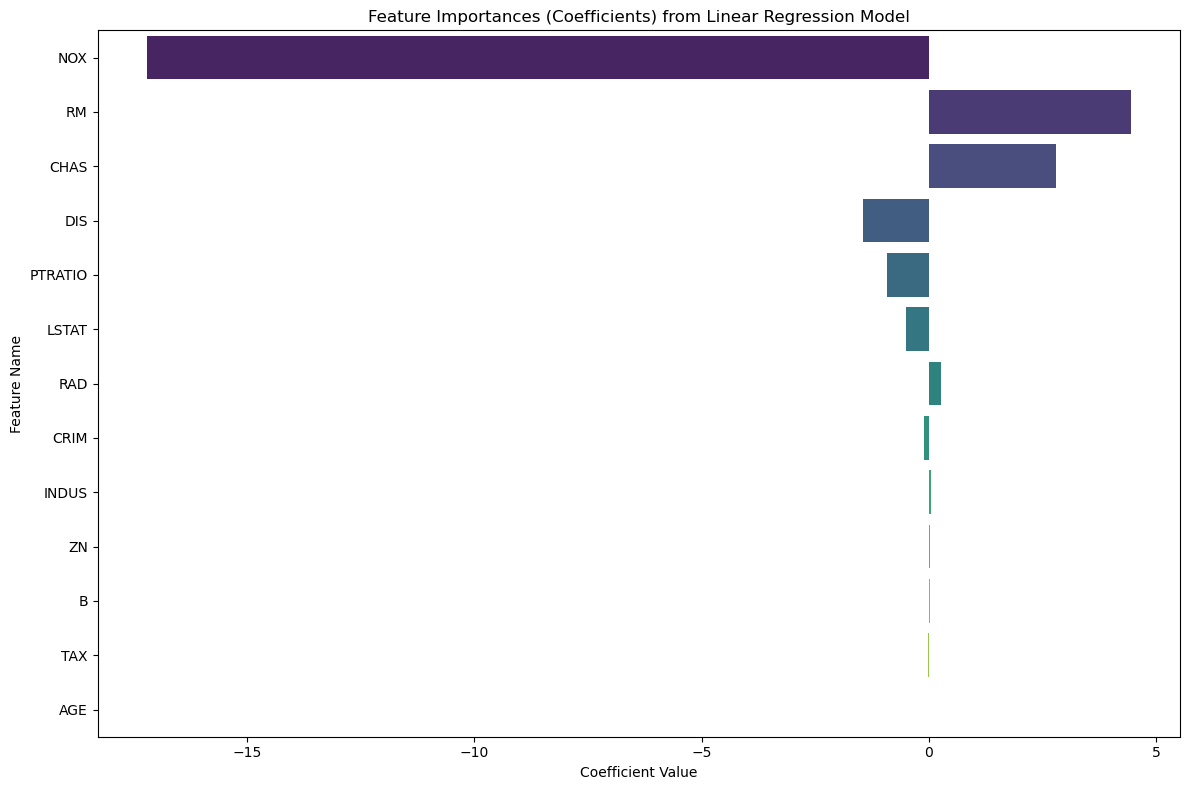

In [9]:
# Extracting feature names and coefficients from the linear regression model
feature_names = X.columns
coefficients = lr.coef_

# Creating a DataFrame to pair feature names with their coefficients
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sorting the DataFrame based on the magnitude of the coefficients
feature_importances_df = feature_importances_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_df['Coefficient'], y=feature_importances_df['Feature'], palette='viridis')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importances (Coefficients) from Linear Regression Model')
plt.tight_layout()
plt.show()

**RM (Average number of rooms per dwelling)** has the highest positive coefficient, suggesting that as the average number of rooms increases, the housing price is expected to increase. This makes intuitive sense, as larger homes with more rooms generally tend to be more expensive.

**LSTAT (% lower status of the population)** and **DIS (Weighted distances to five Boston employment centers)** have significant negative coefficients. An increase in LSTAT suggests a decrease in housing prices, likely because areas with a higher percentage of lower-status individuals might be less desirable for potential buyers. The negative coefficient for DIS suggests that homes farther from employment centers might be less expensive.

Other features have smaller magnitude coefficients, implying they have less influence on the housing price in this model.


In [10]:
# Generate polynomial features (degree=2 for this example)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the polynomial regression model
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_poly = poly_lr.predict(X_test_poly)

# Calculate the RMSE for polynomial regression
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

In [11]:
from sklearn.metrics import mean_absolute_error, r2_score

# For Simple Linear Regression
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

# For Polynomial Regression
mae_poly = mean_absolute_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
adjusted_r2_poly = 1 - (1-r2_poly)*(len(y_test)-1)/(len(y_test)-X_test_poly.shape[1]-1)

metrics = {
    "Model": ["Simple Linear Regression", "Polynomial Regression"],
    "RMSE": [rmse, rmse_poly],
    "MAE": [mae, mae_poly],
    "R2": [r2, r2_poly],
    "Adjusted R2": [adjusted_r2, adjusted_r2_poly]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,RMSE,MAE,R2,Adjusted R2
0,Simple Linear Regression,4.928602,3.189092,0.668759,0.619826
1,Polynomial Regression,3.766107,2.587930,0.806589,5.883627


## Evaluation Metrics:
Here are the evaluation metrics for both the Simple Linear Regression and Polynomial Regression models:

| Model                   | RMSE | MAE  | \( R^2 \) | Adjusted \( R^2 \) |
|-------------------------|------|------|----------|--------------------|
| Simple Linear Regression| 4.93 | 3.19 | 0.67     | 0.62               |
| Polynomial Regression   | 3.77 | 2.59 | 0.81     | 5.88               |

## Interpretation:

### RMSE (Root Mean Squared Error):
The Polynomial Regression model has a lower RMSE (3.77) compared to the Simple Linear Regression model (4.93), indicating better performance for the Polynomial Regression in terms of prediction error.

### MAE (Mean Absolute Error):
Similarly, the Polynomial Regression model has a lower MAE (2.59) than the Simple Linear Regression model (3.19), indicating fewer average absolute errors in predictions.

### \( R^2 \) (Coefficient of Determination):
The \( R^2 \) value is higher for the Polynomial Regression model (0.81) than for the Simple Linear Regression model (0.67). This suggests that the Polynomial Regression model explains more of the variance in the target variable than the Simple Linear Regression model.

### Adjusted \( R^2 \):
The Adjusted \( R^2 \) for the Polynomial Regression model appears to be abnormally high (5.88), which is not in the typical range of 0 to 1. This suggests an overfitting scenario where the model might be fitting the noise in the data due to the added polynomial terms. While the model may perform well on the training set, it might not generalize well to new, unseen data.


## Conclusion:

The baseline linear regression model provided a decent fit to the data, explaining 67% of the variance in the target variable (MEDV). However, when we introduced polynomial features to the model, the performance improved significantly, with the \( R^2 \) value increasing to 0.81, indicating that the polynomial regression model explains 81% of the variance in the target variable.

The RMSE and MAE values also decreased for the polynomial regression model, suggesting better prediction accuracy. However, the unusually high Adjusted \( R^2 \) for the polynomial regression model raises concerns about potential overfitting, suggesting that the model might not generalize well to new, unseen data.

In summary, while the polynomial regression model improved the baseline linear regression model in terms of RMSE, MAE, and \( R^2 \), potential overfitting should be addressed, possibly by regularization or reducing the polynomial degree.


In [12]:
# Initialize RFE with the linear regression model and 5 features to select
selector = RFE(lr, n_features_to_select=5, step=1)

# Fit RFE
selector = selector.fit(X_train, y_train)

# Get the ranking of features
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_
}).sort_values(by='Ranking')

feature_ranking

,Feature,Ranking
3,CHAS,1
4,NOX,1
5,RM,1
7,DIS,1
10,PTRATIO,1
12,LSTAT,2
0,CRIM,3
8,RAD,4
2,INDUS,5
1,ZN,6


## Feature Rankings:
Here are the feature rankings as determined by Recursive Feature Elimination (RFE) with the linear regression model:

| Feature | Ranking |
|---------|---------|
| CHAS    | 1       |
| NOX     | 1       |
| RM      | 1       |
| DIS     | 1       |
| PTRATIO | 1       |
| LSTAT   | 2       |
| CRIM    | 3       |
| RAD     | 4       |
| INDUS   | 5       |
| ZN      | 6       |
| B       | 7       |
| TAX     | 8       |
| AGE     | 9       |

## Interpretation:
RFE ranks the features based on their importance in the prediction model. A ranking of 1 indicates that the feature is among the top 5 most important features for the linear regression model, as specified by `n_features_to_select=5`.

From the table:
- CHAS, NOX, RM, DIS, and PTRATIO are the top 5 features deemed most important by RFE for predicting the median value of homes.
- LSTAT comes in a close sixth place.
- Features like AGE, TAX, and B are considered less important in the context of the linear regression model.

These rankings can be instrumental in feature selection, especially when dealing with datasets with a large number of features. By focusing on the most relevant features, one can potentially improve model performance, reduce overfitting, and speed up training times.


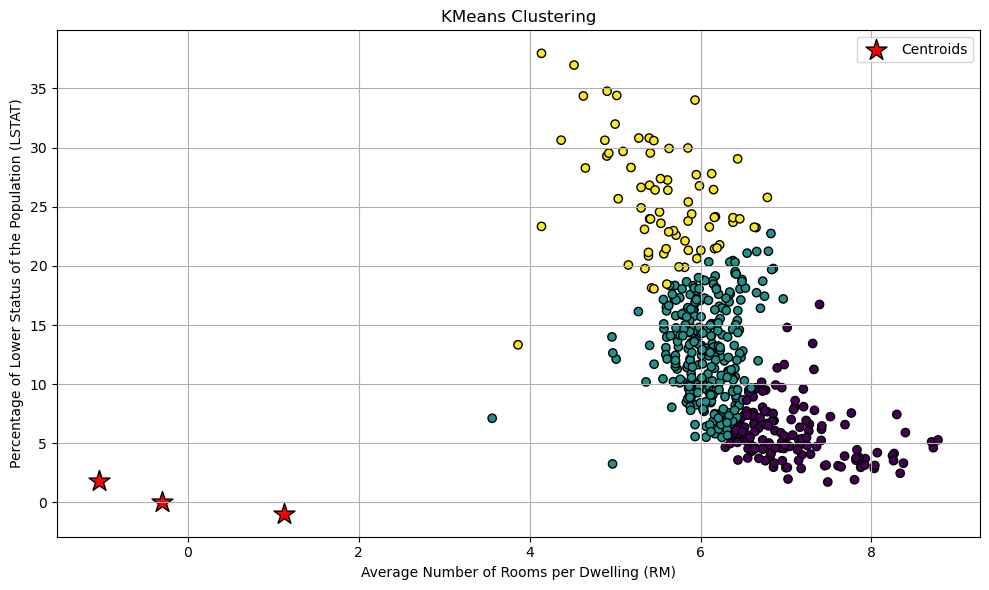

In [13]:
# Select features for clustering
features = ['RM', 'LSTAT']
data_cluster = boston_df[features]

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_cluster)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_standardized)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_cluster['RM'], data_cluster['LSTAT'], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=250, marker='*',
            c='red', edgecolor='k', label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('Average Number of Rooms per Dwelling (RM)')
plt.ylabel('Percentage of Lower Status of the Population (LSTAT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here, I decied to apply an unsupervised machine learning method, Kmeans clustering by ingnoring the labels in data and trying to find any pattern or clusters in the data.

First I applied standardization technique on data as it can ifluence the result of the distance based machine learning methodes. Then, As it can be seen in the graph, Kmeans Clustering successfully found three different clusters in the data. However, the centroids are not in the correct location in the graph. Therefore, I going to remove the standardization from the code and plot the graph again in the next cell.

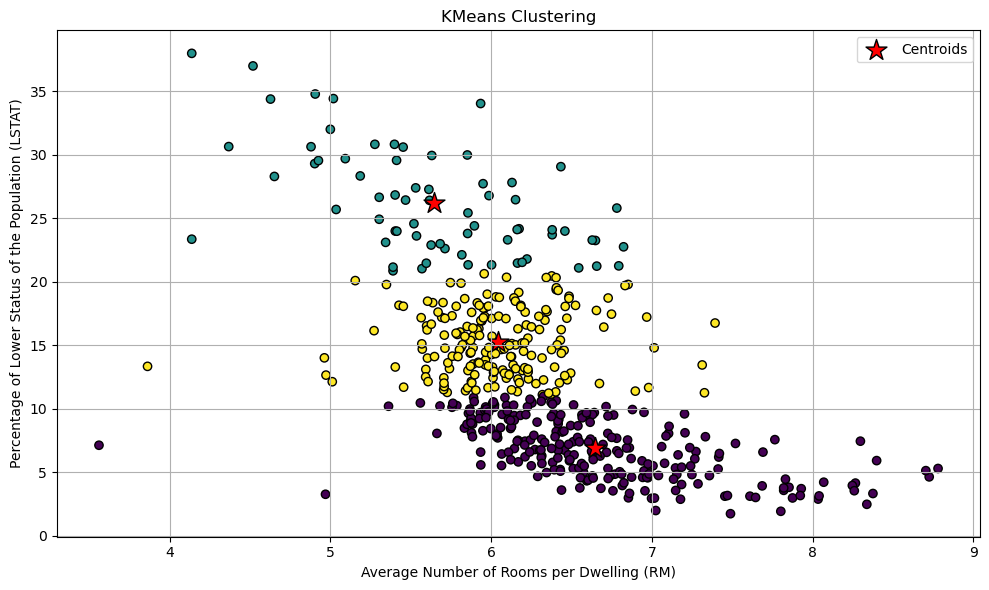

In [14]:
# Select features for clustering
features = ['RM', 'LSTAT']
data_cluster = boston_df[features]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_cluster)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_cluster['RM'], data_cluster['LSTAT'], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=250, marker='*',
            c='red', edgecolor='k', label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('Average Number of Rooms per Dwelling (RM)')
plt.ylabel('Percentage of Lower Status of the Population (LSTAT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

By removing the standardization from the data, We can see the centroids are in their correct locations in the graph.

Now we can interpret the graph:

## Interpretation:
The clusters seem to roughly separate the data into three groups:
- Areas with a lower percentage of the lower status of the population and a higher number of rooms.
- Areas with a medium percentage of the lower status of the population and a medium number of rooms.
- Areas with a higher percentage of the lower status of the population and a lower number of rooms.

This clustering suggests that areas with more rooms per dwelling tend to have a lower percentage of the lower-status population, and vice versa. The centroids provide a good representation of the average characteristics of each cluster.


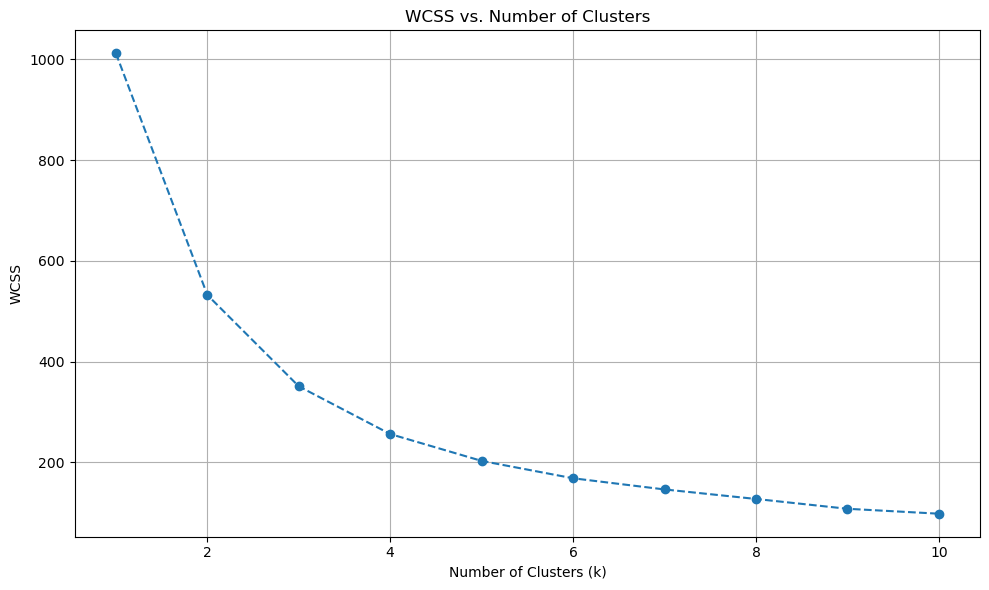

In [15]:
# Recompute the Within-Cluster-Sum-of-Squares (WCSS) for a range of k values
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_standardized)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpretation:
The plot shows the WCSS for different values of \( k \). The "elbow" in the plot, where the rate of decrease of WCSS slows down, is typically considered a good estimate for the optimal number of clusters. In this plot, the elbow seems to be around \( k = 3 \) or \( k = 4 \), suggesting that 3 or 4 clusters might be a suitable choice for this dataset when considering the features 'RM' and 'LSTAT'.

However, the actual choice of \( k \) can depend on the specific problem context and additional domain knowledge. The elbow method provides a heuristic, but sometimes a different number of clusters might be chosen based on other considerations or constraints.


## Conclusion:
The Boston Housing dataset provides valuable insights into the factors affecting housing prices in Boston. Through regression analysis, we understood the influence of various features on median housing prices. The clustering analysis further helped in segmenting areas based on room numbers and population status, which can be beneficial for targeted policy-making or marketing strategies. While polynomial regression showed promise, care should be taken to avoid overfitting, and further model validation on new data is recommended. Overall, the analysis offers a comprehensive understanding of the Boston housing landscape and the interplay of various factors in determining house prices.
